## Initialization

In [ ]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="TDM",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-26 08:59:12,929 - INFO - Logger initialized for 'TDM_20251126_085912'
2025-11-26 08:59:12,930 - INFO - Using device: cuda:0


## Initialization of the Dataset

In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label")

2025-11-26 08:59:12,938 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-26 08:59:13,621 - INFO - Loading dataset into DataFrame
2025-11-26 08:59:32,955 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-26 08:59:52,623 - INFO - ============================================================
2025-11-26 08:59:52,623 - INFO - Preprocessing completed successfully
2025-11-26 08:59:52,624 - INFO - Final dimensions: 1,940,693 rows x 71 columns
2025-11-26 08:59:52,625 - INFO - Total rows removed: 273,776 (12.36%)
2025-11-26 08:59:52,625 - INFO - data retention rate: 87.64%
2025-11-26 08:59:52,625 - INFO - ============================================================
2025-11-26 08:59:52,627 - INFO - Optimizing memory usage of the dataset...
2025-11-26 08:59:52,630 - INFO - Initial memory usage: 1066.05 MB
2025-11-26 08:59:53,471 - INFO - Optimized memory usage: 555.24 MB
2025-11-26 08:59:53,472 - INFO - Memory reduction: 510.82 MB (47.92%)
20

In [3]:
dataset = full_dataset.subset(size=50000, multi_class=False)

2025-11-26 08:59:54,346 - INFO - Subsetting dataset to size: 50000...
2025-11-26 08:59:54,359 - INFO - Class distribution before subsetting:
2025-11-26 08:59:54,360 - INFO -   Class 0: 1528113 samples
2025-11-26 08:59:54,361 - INFO -   Class 1: 412580 samples
2025-11-26 08:59:54,431 - INFO - Subsetted dataset to size: 50000


In [4]:
dataset.distribution()

2025-11-26 08:59:54,524 - INFO - Calculating data distribution...
2025-11-26 08:59:54,526 - INFO - Data Distribution by Attack Type:
2025-11-26 08:59:54,527 - INFO -   0: 25,000 instances
2025-11-26 08:59:54,528 - INFO -   1: 25,000 instances


0    25000
1    25000
Name: count, dtype: int64

In [5]:
X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=True,
    to_tensor=True
)

2025-11-26 08:59:54,540 - INFO - Splitting dataset into training and testing sets...
2025-11-26 08:59:54,854 - INFO - Class distribution before SMOTE:
2025-11-26 08:59:54,855 - INFO -   Class 0.0: 20011 samples
2025-11-26 08:59:54,855 - INFO -   Class 1.0: 19989 samples
2025-11-26 08:59:54,856 - INFO - Class distribution after SMOTE:
2025-11-26 08:59:54,857 - INFO -   Class 0.0: 20011 samples
2025-11-26 08:59:54,857 - INFO -   Class 1.0: 19989 samples


In [6]:
# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input size: {input_size}, Num classes: {num_classes}")

model_type = f"{input_size}x{num_classes}"

criterion = nn.CrossEntropyLoss()

Input size: 70, Num classes: 2


## Multi Layers Perceptron (MLP)

In [8]:
model_mlp = NetworkIntrusionMLP(
    input_size=input_size,
    layer_features=[128, 64, 32],
    layer_classifier=[16],
    num_classes=num_classes,
    scaling_method="minmax",
    device=device
).fit_scalers(X_train=X_train)

logger.info(f"MLP Model initialized with {model_mlp.num_params()} parameters")

learning_rate_mlp = 1e-2
num_epochs_mlp = 100

mlp_title = f"MLP_{model_type}_{num_epochs_mlp}"

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=10, min_lr=1e-6)

2025-11-26 08:59:55,074 - INFO - MLP Model initialized with 20434 parameters


In [9]:
model_mlp, train_losses_mlp, val_losses_mlp = train(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs_mlp,
    title=mlp_title,
    root_dir=root_dir,
    logger=logger,
    device=device,
)

Loss: 0.0539, Val Loss: 0.0522, LR: 0.006400: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


2025-11-26 09:01:29,596 - INFO - Plotting loss curve...
2025-11-26 09:01:30,332 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/results/loss_plots/TDM_20251126_085912_MLP_70x2_100_loss.png


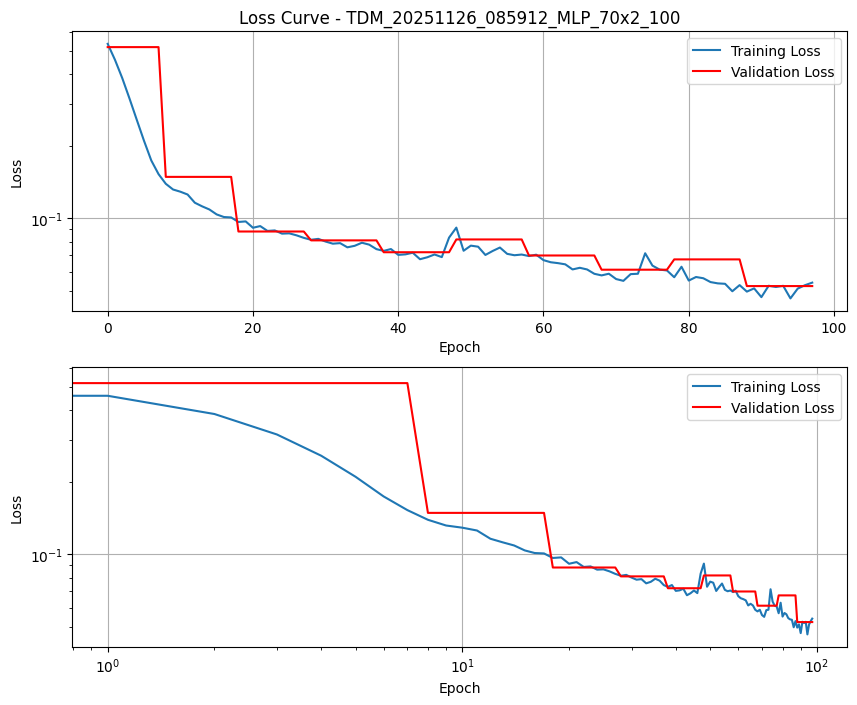

In [10]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title=f"{title}_{mlp_title}",
    root_dir=root_dir,
    plot=True,
    logger=logger,
    epoch_min=2
)

2025-11-26 09:01:30,545 - INFO - Running analysis for PyTorch model: TDM_20251126_085912_MLP_70x2_100 on device: cuda:0


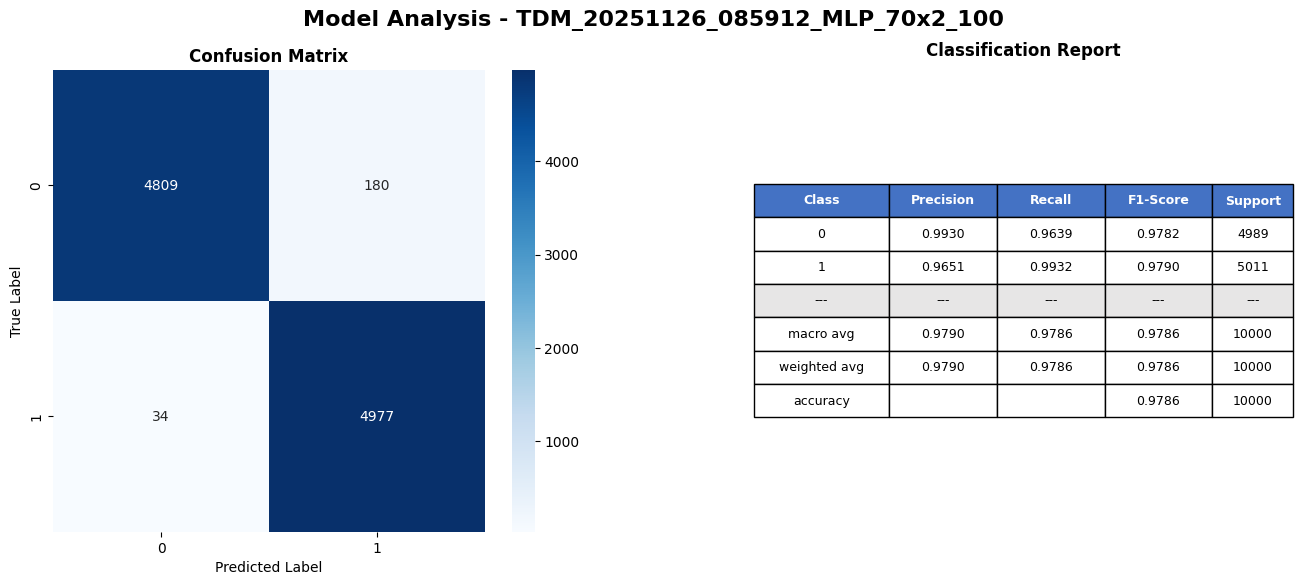

In [11]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_val,
    y_test=y_val,
    logger=logger,
    title=f"{title}_{mlp_title}",
    root_dir=root_dir,
    plot=True,
    device=device
)

model_mlp = model_mlp.cpu()